# Module 6 - Mapping water from satellites

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/DHI/Intro_ML_course/blob/main/module_6/6_water_mapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

In this module, we will explore the fascinating world of remote sensing using Sentinel-2 satellite imagery. Our focus will be on mapping water using different bands of light over the Brahmaputra river.

In [1]:
# Necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import numpy.random
import os
from sklearn.cluster import KMeans


Satellite imagery has become an invaluable tool in various fields, providing a unique perspective on our planet from above. One of the remarkable features of satellite technology is its ability to capture light beyond the visible spectrum that the human eye can perceive. Infrared (IR) is one such type of radiation that satellites like Sentinel-2 can detect.

Infrared can reveal information about surface temperatures, vegetation health, and even atmospheric conditions. For instance, healthy vegetation reflects more infrared light than unhealthy or non-vegetative surfaces.

## 1. Load Sentinel-2 satellite images

In the upcoming exercises, we'll explore Sentinel-2 imagery of the Brahmaputra river, utilizing both visible and infrared bands. This advanced technology allows us to gain insights into environmental patterns and changes that are often invisible to the naked eye.

In [2]:
!wget https://raw.githubusercontent.com/DHI/Intro_ML_course/main/module_6/Brahmaputra_images.zip
!unzip Brahmaputra_images.zip

--2023-11-29 12:00:07--  https://raw.githubusercontent.com/DHI/Intro_ML_course/main/module_6/Brahmaputra_images.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24454532 (23M) [application/zip]
Saving to: ‘Brahmaputra_images.zip’

Brahmaputra_images. 100%[===================>]  23.32M  --.-KB/s    in 0.07s   

2023-11-29 12:00:07 (322 MB/s) - ‘Brahmaputra_images.zip’ saved [24454532/24454532]

Archive:  Brahmaputra_images.zip
  inflating: Brahmaputra-2021-02-22T04.npy  
  inflating: Brahmaputra-2022-03-09T04.npy  
  inflating: Brahmaputra-2022-11-29T04.npy  
  inflating: Brahmaputra-2023-02-02T04.npy  


In [3]:
files = sorted([file for file in os.listdir('.') if file.endswith('.npy')])
images = [np.load(os.path.join('.', file)).astype('float') for file in files]
images = [np.moveaxis(image, source=0, destination=-1) for image in images]
images = [np.clip(image, 0, 1) for image in images]
print('There are', len(images), 'images of shape:', images[0].shape)

There are 4 images of shape: (1009, 1014, 4)


Each image has the following shape (1009, 1014, 4):
- 1009 pixels high (around 10 kilometers)
- 1014 pixels wide (around 10 kilometers)
- 4 spectral bands: blue, green, red, near-infrared  

These four bands are only a selection, this satellite records information for 11 wavelengths. Here we only selected blue, green, red and infrared.

## 2. Visualize satellite imagery

### In natural colors

To begin our exploration, we'll visualize the Sentinel-2 image in natural color. Natural color images represent the scene as it would appear to the human eye – using red, green, and blue channels. These channels capture the visible spectrum of light.

We use the red channel to represent the red light, the green channel for green light, and the blue channel for blue light. This combination provides a true-to-life depiction of the landscape.

In [4]:
rgb = (2, 1, 0) # red, green, blue bands

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6))
for i in range(2):
  for j in range(2):
      index = i * 2 + j
      axes[i, j].imshow(images[index][:, :, rgb])
      axes[i, j].set_title(f'Date: {files[index][12:22]}')
      axes[i, j].axis('off')
plt.tight_layout()
plt.show()

### In false colors

Now, let's explore the concept of false color imagery using Sentinel-2 data. In false color images, different bands are assigned to specific color channels to highlight features that may not be visible in natural color. A common combination is using the near-infrared (NIR) band, the red band, and the blue band.

The near-infrared band is particularly useful for vegetation analysis. In this combination, healthy vegetation appears bright red, while non-vegetative surfaces take on different colors. This visualization technique enhances the contrast of land cover types and unveils patterns that may not be apparent in visible light.

In [6]:
false_colors = (3, 2, 0) # infrared, red, blue bands

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6))
for i in range(2):
  for j in range(2):
      index = i * 2 + j
      axes[i, j].imshow(images[index][:, :, false_colors])
      axes[i, j].set_title(f'Date: {files[index][12:22]}')
      axes[i, j].axis('off')
plt.tight_layout()
plt.show()

See how simpler it is to differentiate vegetation, soil and water in false colors!

## 4. Clusters of pixels

Now that we've visualized the image in different color spaces, we'll take a closer look at specific bands – red and infrared. This step involves creating a scatter plot where each pixel's red reflectance is plotted on the x-axis, and infrared reflectance on the y-axis.

### Convert the images into tabular data

Each row of the resuting table will correspond to one pixel for one date. For instance, the first row is pixel (1, 1) on 22nd of February 2022.

Each column will correspond to the intensity of a spectral band (blue, green, red or near infrared).

In [8]:
# transform the images into a long table
data = np.array(images).reshape(-1, 4)
data.shape

(4092504, 4)

We select a small random subset of these 4 millions of data points for visualization.

In [9]:
# we select only a random subset of pixels to display
sample_size = 100000
random_indices = np.random.choice(data.shape[0], size=10000, replace=False)
data_subset = data[random_indices]
data_subset.shape

(10000, 4)

Let's display the distributions of the red and infrared intensities in a scatterplot - each dot represents a pixel.

(0.0, 1.0)

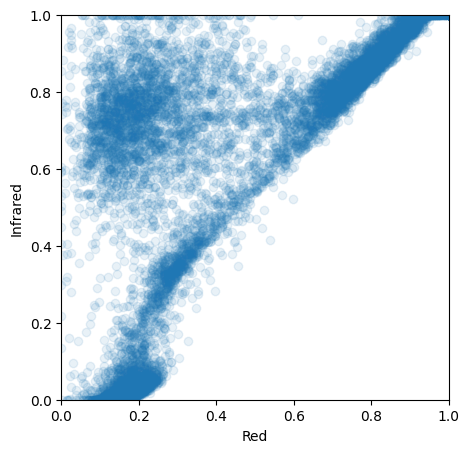

In [10]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(data_subset[:, 2], data_subset[:, 3], alpha=0.1)
plt.xlabel('Red')
plt.ylabel('Infrared')
plt.xlim(0, 1)
plt.ylim(0, 1)

## 5. Clustering

This scatter plot helps us identify different clusters corresponding to water bodies, vegetation, and soil. Water tends to have low reflectance in both red and infrared, while vegetation exhibits high infrared but low red reflectance.


We'll use a clustering technique called K-Means to automatically group pixels into these clusters. For more information about K-Means, you can look at the following resources:
- [Google for Developers guide on clustering](https://developers.google.com/machine-learning/clustering/algorithm/run-algorithm)
- [Scikit-learn user guide on clustering](https://scikit-learn.org/stable/modules/clustering.html#k-means)

In [11]:
# Select a number of clusters
num_clusters = 5

In [12]:
# Fit the K-Means model to cluster the selected data
kmeans = KMeans(n_clusters=num_clusters)
labels = kmeans.fit_predict(data_subset)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [13]:
# Retrieve the K-Means cluster centroids
cluster_centers = kmeans.cluster_centers_

(0.0, 1.0)

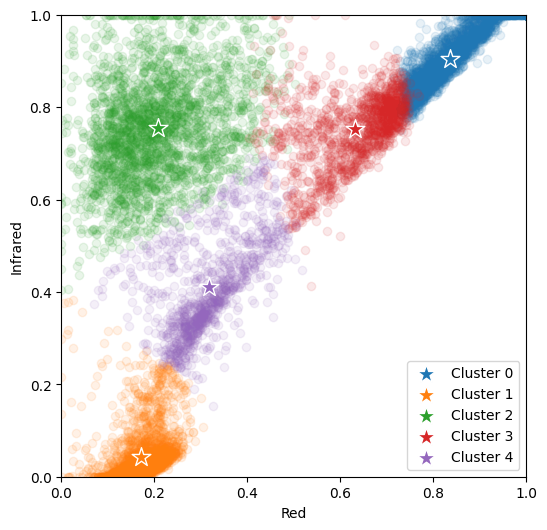

In [14]:
fig = plt.figure(figsize=(6, 6))
colors = ['C0', 'C1', 'C2', 'C3', 'C4']
for i in range(num_clusters):
    # plot pixels in different colors
    plt.scatter(data_subset[labels==i, 2], data_subset[labels==i, 3],
                color=f'C{i}', alpha=0.1)
    # plot cluster centers as stars
    plt.scatter(cluster_centers[i, 2], cluster_centers[i, 3],
                color=f'C{i}', s=200, marker='*',
                edgecolors='white', label=f'Cluster {i}')
plt.xlabel('Red')
plt.ylabel('Infrared')
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)

In [15]:
# Assign each pixel in the image to the nearest cluster centroid
assigned_clusters = kmeans.predict(data)

# Reshape the assigned clusters to the shape of the original image
assigned_clusters = assigned_clusters.reshape((4,) + images[0].shape[:2])

In [16]:
assigned_clusters.shape

(4, 1009, 1014)

In [17]:
cluster_colors = [[0, 128, 255], [255, 153, 51], [0, 153, 0],
 [204, 0, 0], [150, 0, 180]]

In [18]:
# Use the assigned clusters and calculated colors to create an annotated image
annotated_image = np.zeros(assigned_clusters.shape + (3, ),  dtype=np.uint8)
for cluster_id in range(num_clusters):
    annotated_image[assigned_clusters == cluster_id] = cluster_colors[cluster_id]

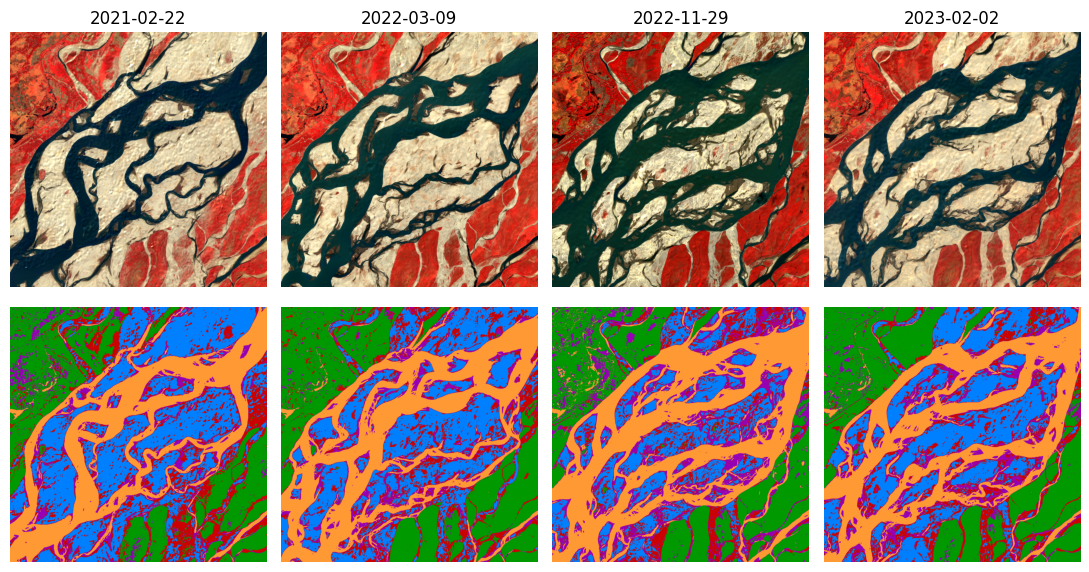

In [19]:
fig, axes = plt.subplots(2, 4, figsize=(11, 6))
for i in range(4):
    axes[0, i].imshow(images[i][:, :, false_colors])
    axes[0, i].set_title(files[i][12:22])
    axes[0, i].axis('off')
    axes[1, i].imshow(annotated_image[i])
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()

#### **Exercise**: what happens if you decrease or increase `n_clusters` ?

## 6. Water mapping

One of the clusters correspond to water.

In [22]:
# select the number of the cluster which corresponds to water
water_cluster = 1 # Change the '_' to a number between 0 and 3

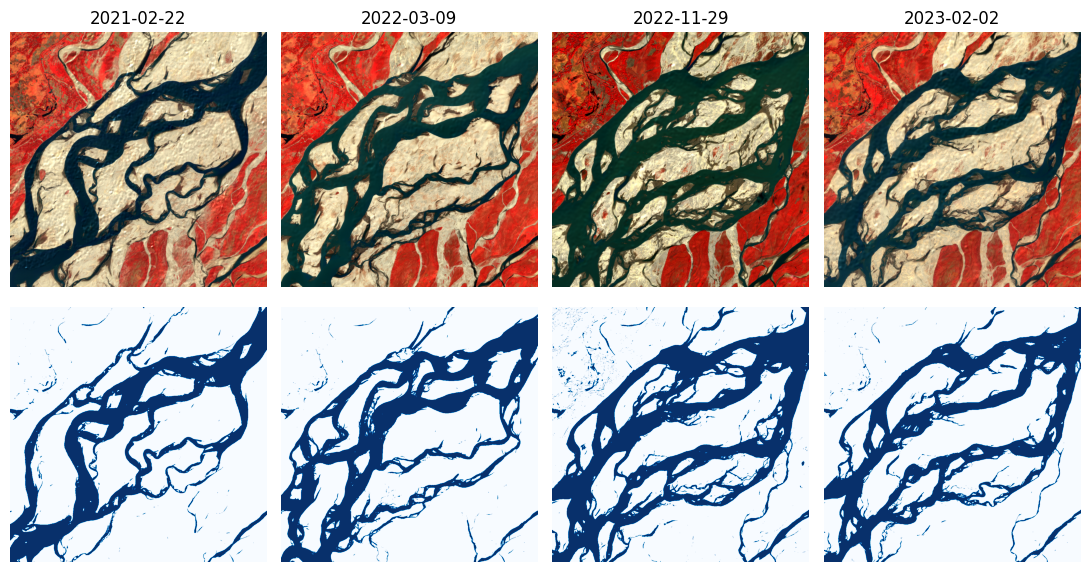

In [23]:
fig, axes = plt.subplots(2, 4, figsize=(11, 6))
for i in range(4):
    axes[0, i].imshow(images[i][:, :, false_colors])
    axes[0, i].set_title(files[i][12:22])
    axes[0, i].axis('off')
    axes[1, i].imshow(assigned_clusters[i]==water_cluster, cmap='Blues')
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()

#### **Exercise**: Find out what areas are always flooded, which ones are always dry and which ones vary

In [24]:
plt.imshow(np.mean(assigned_clusters==water_cluster, axis=0), cmap='Blues')

### **Second notebook**

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/DHI/Intro_ML_course/blob/main/module_6/6_convolutional_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>